# Analysis: Correlations between meta-`features` and model `metrics`

Imports

In [45]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Load dataset

In [22]:
meta_regression_path = str(Path(os.getcwd()).parent) + "/src/artifacts/analysis/meta_regression_coefficients.csv"

In [23]:
meta_regression_df = pd.read_csv(meta_regression_path)
meta_regression_df

,prior,n_samples,intercept,attr_conc.mean,attr_conc.sd,attr_ent.mean,attr_ent.sd,attr_to_inst,can_cor.mean,can_cor.sd,...,sd.sd,skewness.mean,skewness.sd,sparsity.mean,sparsity.sd,t_mean.mean,t_mean.sd,var.mean,var.sd,w_lambda
0,isotropic_gaussian,47,1.426147,-1.504491,0.800004,0.021746,-0.091135,0.296574,0.117560,0.113823,...,1.005109,-0.025869,-0.002521,-0.794882,0.220969,0.465327,-5.484925,-0.796385,0.487464,-0.063564
1,laplace,47,1.425072,0.736606,0.978226,0.013683,-0.082662,-2.026697,0.052234,-0.340630,...,-2.460070,-0.003209,-0.001345,0.954507,-4.928957,-0.181102,3.988638,6.473962,-1.168260,0.017494
2,student_t,47,1.430851,-1.762593,1.320438,0.004991,-0.063308,0.689531,0.068842,0.191669,...,1.362799,-0.022500,-0.001625,-1.146272,-0.031842,0.575032,-5.017114,-2.675085,0.652459,-0.034845


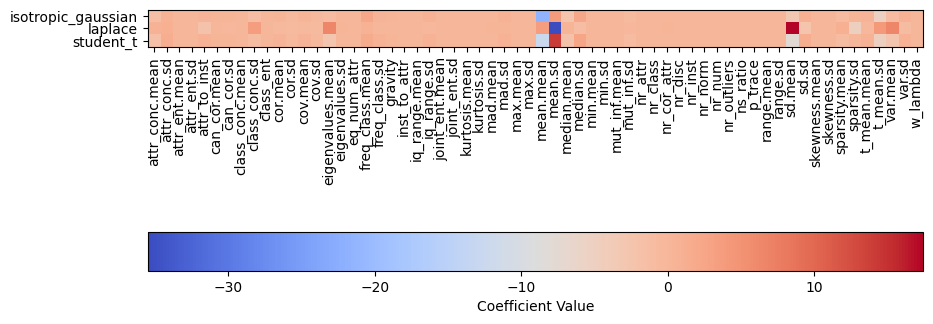

In [42]:
plt.figure(figsize=(10, 8))
plt.imshow(meta_regression_df.drop(columns=["prior", "n_samples", "intercept"]).to_numpy(), cmap="coolwarm")
plt.colorbar(label="Coefficient Value", orientation="horizontal", pad=0.3)
plt.yticks(ticks=range(len(meta_regression_df)), labels=meta_regression_df["prior"])
plt.xticks(ticks=range(len(meta_regression_df.columns)-3), labels=meta_regression_df.columns[3:], rotation=90)
plt.show()

In [24]:
isotropic_gaussian_coefficients = meta_regression_df[meta_regression_df['prior'] == 'isotropic_gaussian'].drop(columns=['prior'])
laplace_coefficients = meta_regression_df[meta_regression_df['prior'] == 'laplace'].drop(columns=['prior'])
student_t_coefficients = meta_regression_df[meta_regression_df['prior'] == 'student_t'].drop(columns=['prior'])

In [25]:
diff = isotropic_gaussian_coefficients.reset_index(drop=True) - laplace_coefficients.reset_index(drop=True)
diff

,n_samples,intercept,attr_conc.mean,attr_conc.sd,attr_ent.mean,attr_ent.sd,attr_to_inst,can_cor.mean,can_cor.sd,class_conc.mean,...,sd.sd,skewness.mean,skewness.sd,sparsity.mean,sparsity.sd,t_mean.mean,t_mean.sd,var.mean,var.sd,w_lambda
0,0,0.001076,-2.241097,-0.178221,0.008063,-0.008474,2.323271,0.065326,0.454453,-0.004497,...,3.46518,-0.02266,-0.001176,-1.749389,5.149925,0.646429,-9.473563,-7.270347,1.655723,-0.081058


In [26]:
diff = isotropic_gaussian_coefficients.reset_index(drop=True) - student_t_coefficients.reset_index(drop=True)
diff

,n_samples,intercept,attr_conc.mean,attr_conc.sd,attr_ent.mean,attr_ent.sd,attr_to_inst,can_cor.mean,can_cor.sd,class_conc.mean,...,sd.sd,skewness.mean,skewness.sd,sparsity.mean,sparsity.sd,t_mean.mean,t_mean.sd,var.mean,var.sd,w_lambda
0,0,-0.004704,0.258102,-0.520434,0.016754,-0.027827,-0.392957,0.048718,-0.077846,0.033883,...,-0.35769,-0.003369,-0.000896,0.35139,0.252811,-0.109705,-0.467811,1.8787,-0.164995,-0.028718


In [58]:
df = meta_regression_df.copy()
id_col = "prior"
value_cols = [c for c in df.columns if c != id_col]
long_df = df.melt(id_vars=[id_col], value_vars=value_cols, var_name="feature", value_name="coef")

coef_table = long_df.pivot_table(index="feature", columns="prior", values="coef", aggfunc="first")

priors = coef_table.columns.tolist()
expected = ["isotropic_gaussian", "laplace", "student_t"]
available = [p for p in expected if p in priors]

# Compute pairwise diffs
def diff_cols(tab, a, b):
    if a in tab.columns and b in tab.columns:
        s = tab[a] - tab[b]
        return s.rename(f"{a} - {b}")
    return None

diff_iso_lap = diff_cols(coef_table, "isotropic_gaussian", "laplace")
diff_iso_t   = diff_cols(coef_table, "isotropic_gaussian", "student_t")

def topk_from_series(s, k=25):
    if s is None:
        return pd.Index([])
    return s.abs().sort_values(ascending=False).head(k).index

top_iso_lap = topk_from_series(diff_iso_lap, 25)
top_iso_t   = topk_from_series(diff_iso_t, 25)
top_features = pd.Index(top_iso_lap).union(pd.Index(top_iso_t))

if len(top_features) == 0:
    overall = coef_table.abs().max(axis=1)
    top_features = overall.sort_values(ascending=False).head(25).index
plot_tab = coef_table.loc[top_features]
if plot_tab.shape[0] > 20:
    mean_abs = plot_tab.abs().mean(axis=1)
    plot_tab = plot_tab.loc[mean_abs.sort_values(ascending=False).head(20).index]

sort_key = plot_tab["isotropic_gaussian"] if "isotropic_gaussian" in plot_tab.columns else plot_tab.mean(axis=1)
plot_tab = plot_tab.loc[sort_key.sort_values(ascending=False).index]

In [59]:
def shorten(label, maxlen=32):
    s = str(label)
    return s if len(s) <= maxlen else s[:maxlen-1] + "…"

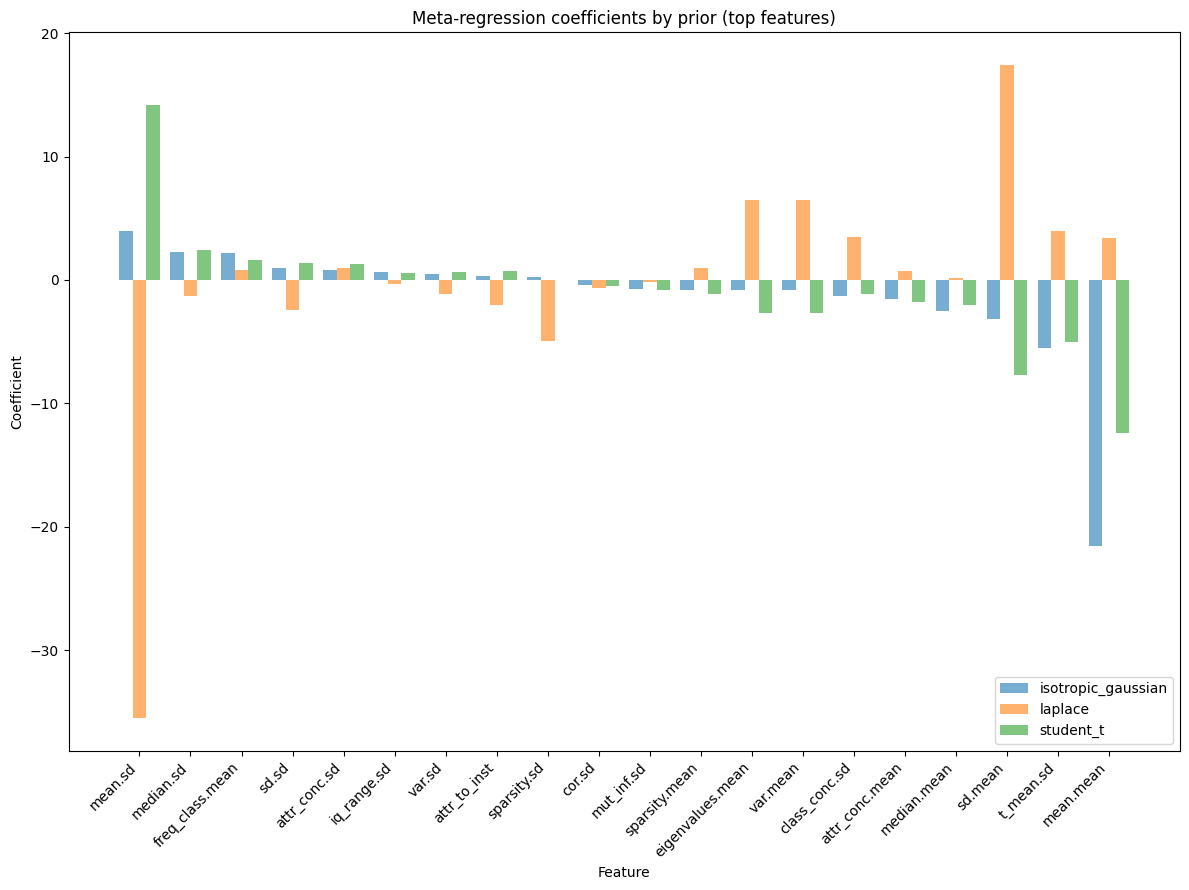

In [61]:
fig1, ax1 = plt.subplots(figsize=(12, 6 + 0.15 * len(plot_tab)))
x = np.arange(len(plot_tab.index))
width = 0.8 / max(1, len(plot_tab.columns))

for j, col in enumerate(plot_tab.columns):
    ax1.bar(x + j*width - (len(plot_tab.columns)-1)*width/2, plot_tab[col].values, width=width, label=str(col), alpha=0.6)

ax1.set_xticks(x)
ax1.set_xticklabels([shorten(f) for f in plot_tab.index], rotation=45, ha="right")
ax1.set_title("Meta-regression coefficients by prior (top features)")
ax1.set_xlabel("Feature")
ax1.set_ylabel("Coefficient")
ax1.legend(loc="best")
plt.tight_layout()
plt.show()

# Correlations

In [62]:
correlations_path = str(Path(os.getcwd()).parent) + "/src/artifacts/analysis/feature_metric_correlations.csv"
correlations_df = pd.read_csv(correlations_path)
correlations_df

,prior,method,metric,feature,n,r,p_value
0,isotropic_gaussian,pearson,accept_rate,attr_conc.mean,51,-0.163596,2.513417e-01
1,isotropic_gaussian,pearson,accept_rate,attr_conc.sd,51,-0.574472,1.042364e-05
2,isotropic_gaussian,pearson,accept_rate,attr_ent.mean,51,-0.204114,1.508024e-01
3,isotropic_gaussian,pearson,accept_rate,attr_ent.sd,51,-0.806281,9.345857e-13
4,isotropic_gaussian,pearson,accept_rate,attr_to_inst,51,0.425608,1.848056e-03
...,...,...,...,...,...,...,...
2971,student_t,spearman,seed,t_mean.mean,51,0.551457,2.739713e-05
2972,student_t,spearman,seed,t_mean.sd,51,-0.732361,1.010258e-09
2973,student_t,spearman,seed,var.mean,51,0.026782,8.520103e-01
2974,student_t,spearman,seed,var.sd,51,-0.760366,9.633649e-11


In [119]:
def plot_feature_metric_correlations(
    corr_df: pd.DataFrame,
    *,
    prior: str,
    method: str = "pearson",
    annotate: bool = False,
    sort_by: str = "absmean",   # {"absmean", "alpha", None}
    vmin: float = -1.0,
    vmax: float =  1.0,
    figsize: tuple[int, int] | None = None,
    ax: plt.Axes | None = None,
    cmap: str = "coolwarm",
    save_path: str | None = None,
    # NEW: canonical orders to keep labels/values aligned across different data
    feature_order: list[str] | None = None,
    metric_order: list[str] | None = None,
) -> plt.Axes:
    df = corr_df
    if df.empty:
        raise ValueError("corr_df is empty.")
    method = method.lower()
    if method not in {"pearson", "spearman"}:
        raise ValueError("method must be 'pearson' or 'spearman'.")

    sub = df[(df["prior"] == prior) & (df["method"] == method)].copy()
    if sub.empty:
        raise ValueError(f"No correlations found for prior={prior!r}, method={method!r}.")

    # --- Establish canonical orders (stable across calls) ---
    # If not provided, derive from the *full* corr_df so positions don't jump
    if feature_order is None:
        feature_order = sorted(df["feature"].unique().tolist())
    if metric_order is None:
        metric_order = sorted(df["metric"].unique().tolist())

    # Pivot to feature × metric matrix
    mat = sub.pivot_table(index="feature", columns="metric", values="r", aggfunc="mean")

    # Reindex to canonical orders; missing entries become NaN but positions are fixed
    mat = mat.reindex(index=feature_order, columns=metric_order)

    # Optional sorting for readability — only when no explicit order is supplied
    if feature_order is None and metric_order is None:
        if sort_by == "absmean":
            r_absmean_rows = mat.abs().mean(axis=1).sort_values(ascending=False)
            r_absmean_cols = mat.abs().mean(axis=0).sort_values(ascending=False)
            mat = mat.loc[r_absmean_rows.index, r_absmean_cols.index]
        elif sort_by == "alpha":
            mat = mat.sort_index(axis=0).sort_index(axis=1)
    else:
        # Respect explicit orders; ignore sort_by to preserve consistency
        sort_by = None

    # Figure/Axes
    if ax is None:
        if figsize is None:
            h = max(6, int(0.40 * max(1, mat.shape[0])) + 2)
            w = max(6, int(0.50 * max(1, mat.shape[1])) + 2)
            figsize = (w, h)
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    # Use a masked array so NaNs don’t draw as zeros
    a = mat.to_numpy()
    a_masked = np.ma.masked_invalid(a)
    im = ax.imshow(a_masked, vmin=vmin, vmax=vmax, aspect="auto", cmap=cmap)
    # If desired, make NaNs visibly distinct:
    im.cmap.set_bad(alpha=0.0)  # transparent cells for missing combos

    # Ticks/labels (aligned with the canonical order)
    ax.set_xticks(np.arange(mat.shape[1]))
    ax.set_yticks(np.arange(mat.shape[0]))
    ax.set_xticklabels(list(mat.columns), rotation=90, ha="right")
    ax.set_yticklabels(list(mat.index))

    # Gridlines for readability
    ax.set_xticks(np.arange(-.5, mat.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, mat.shape[0], 1), minor=True)
    ax.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
    ax.tick_params(which="both", length=0)

    # Annotations
    if annotate:
        for i in range(a.shape[0]):
            for j in range(a.shape[1]):
                val = a[i, j]
                if np.isfinite(val):
                    ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)

    # Colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.2, pad=0.1, aspect=50)
    cbar.set_label("Correlation (r)")

    ax.set_title("Feature-Metric Correlations", fontsize=12)
    ax.figure.suptitle(prior, fontsize=18, y=0.98)

    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches="tight")
    return ax

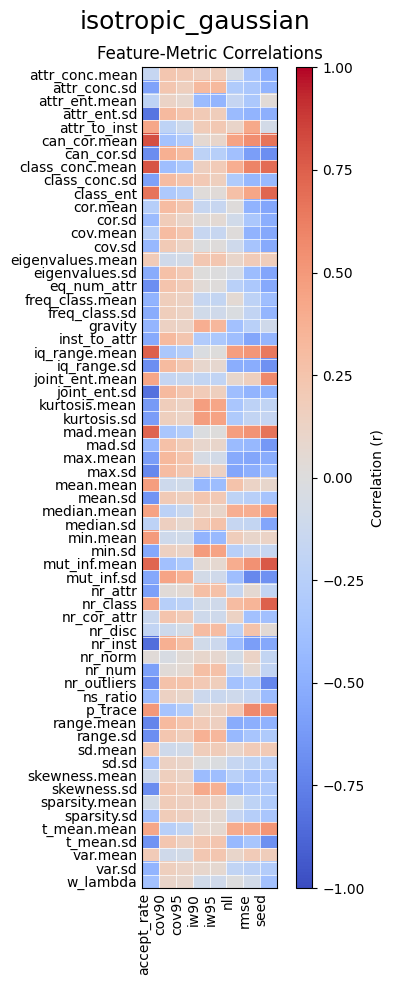

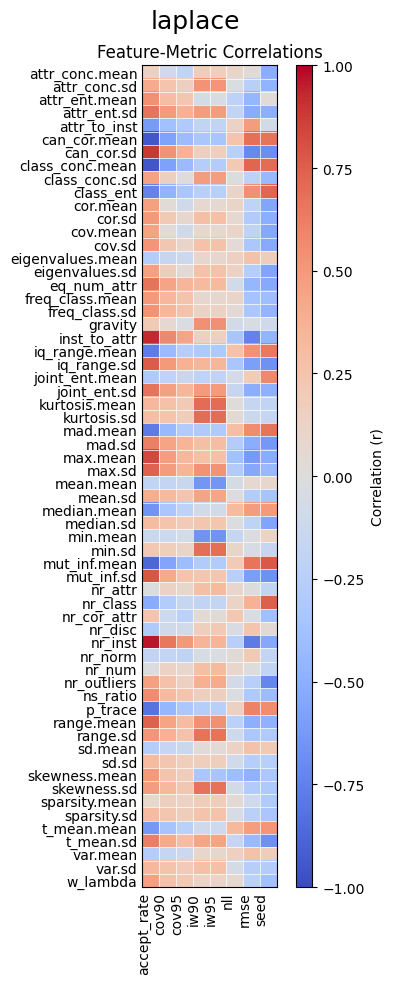

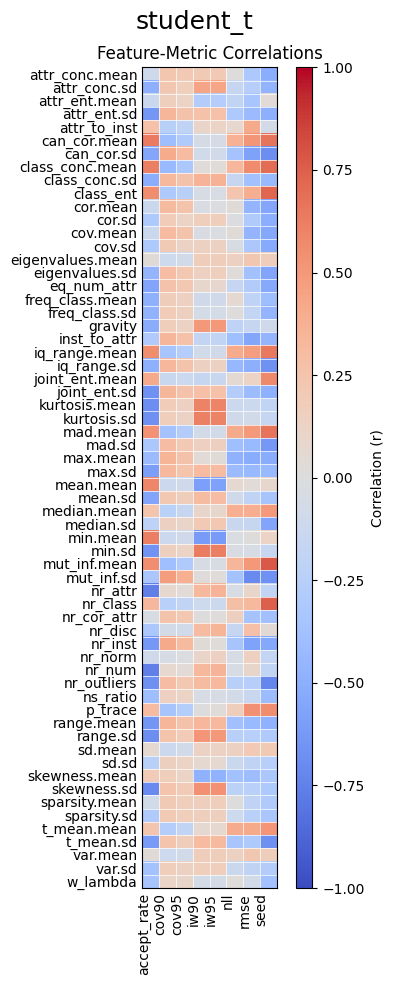

In [120]:
for prior in correlations_df["prior"].dropna().unique():
    fig, ax = plt.subplots(figsize=(4,10))
    plot_feature_metric_correlations(
        correlations_df,
        prior=prior,
        method="pearson",
        annotate=False,
        sort_by="absmean",
        save_path=None,
        ax=ax,
    )
    plt.tight_layout()
    plt.show()

In [ ]:
def _corr_matrix(corr_df, *, prior, method, feature_order=None, metric_order=None):
    sub = corr_df[(corr_df["prior"] == prior) & (corr_df["method"] == method)]
    if sub.empty:
        raise ValueError(f"No correlations for prior={prior!r}, method={method!r}.")
    mat = sub.pivot_table(index="feature", columns="metric", values="r", aggfunc="mean")
    if feature_order is None:
        feature_order = sorted(corr_df["feature"].unique())
    if metric_order is None:
        metric_order = sorted(corr_df["metric"].unique())
    return mat.reindex(index=feature_order, columns=metric_order)

def plot_feature_metric_diff(
    corr_df: pd.DataFrame,
    *,
    prior_a: str,
    prior_b: str,
    method: str = "pearson",
    annotate: bool = False,
    cmap: str = "coolwarm",
    figsize: tuple[int, int] | None = None,
    ax: plt.Axes | None = None,
    feature_order: list[str] | None = None,
    metric_order: list[str] | None = None,
) -> plt.Axes:
    if feature_order is None:
        feature_order = sorted(corr_df["feature"].unique())
    if metric_order is None:
        metric_order = sorted(corr_df["metric"].unique())

    A = _corr_matrix(corr_df, prior=prior_a, method=method,
                     feature_order=feature_order, metric_order=metric_order)
    B = _corr_matrix(corr_df, prior=prior_b, method=method,
                     feature_order=feature_order, metric_order=metric_order)
    D = A - B

    if ax is None:
        if figsize is None:
            h = max(6, int(0.40 * max(1, D.shape[0])) + 2)
            w = max(6, int(0.50 * max(1, D.shape[1])) + 2)
            figsize = (w, h)
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    vmax = np.nanmax(np.abs(D.to_numpy()))
    vmax = 1e-12 if not np.isfinite(vmax) or vmax == 0 else float(vmax)
    vmin = -vmax

    a = np.ma.masked_invalid(D.to_numpy())
    im = ax.imshow(a, vmin=vmin, vmax=vmax, aspect="auto", cmap=cmap)
    im.cmap.set_bad(alpha=0.0)

    ax.set_xticks(np.arange(D.shape[1]))
    ax.set_yticks(np.arange(D.shape[0]))
    ax.set_xticklabels(D.columns, rotation=90, ha="right")
    ax.set_yticklabels(D.index)

    ax.set_xticks(np.arange(-.5, D.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, D.shape[0], 1), minor=True)
    ax.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
    ax.tick_params(which="both", length=0)

    if annotate:
        arr = D.to_numpy()
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                val = arr[i, j]
                if np.isfinite(val):
                    ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)

    cbar = fig.colorbar(im, ax=ax, fraction=0.2, pad=0.1, aspect=50)
    cbar.set_label(f"Δ correlation (r): {prior_a} - {prior_b}")

    ax.set_title(f"Difference: {prior_a} - {prior_b}", fontsize=12)
    fig.tight_layout()
    return ax


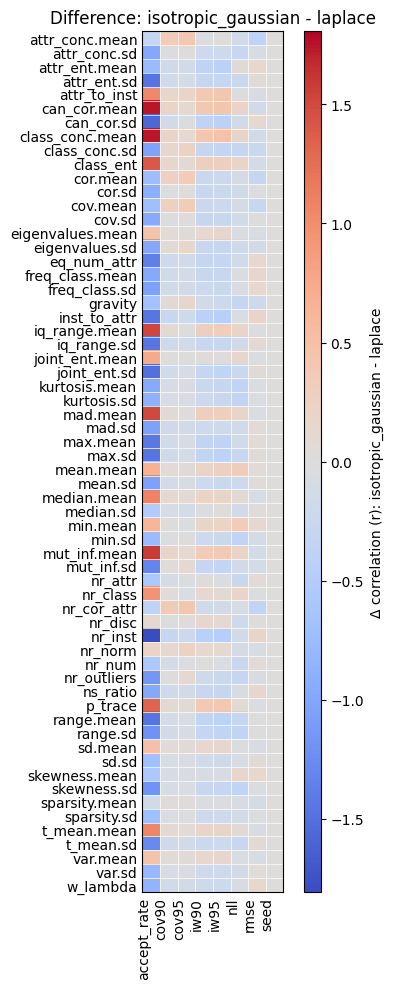

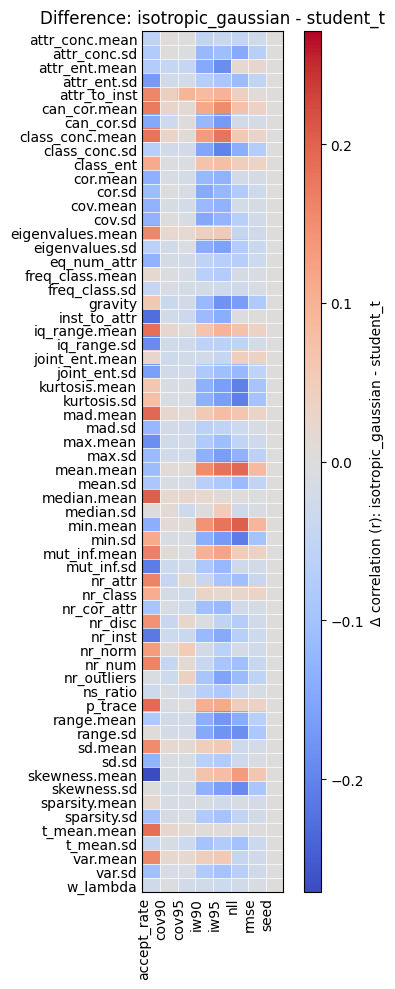

In [ ]:
feat_order = sorted(correlations_df["feature"].unique())
metr_order = sorted(correlations_df["metric"].unique())

# difs
pairs = [("isotropic_gaussian", "laplace"), ("isotropic_gaussian", "student_t")]

for a, b in pairs:
    fig, ax = plt.subplots(figsize=(4, 10))
    plot_feature_metric_diff(
        correlations_df,
        prior_a=a,
        prior_b=b,
        method="pearson",
        annotate=False,
        feature_order=feat_order,
        metric_order=metr_order,
        ax=ax,
    )
    plt.tight_layout()
    plt.show()